# Initialization

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Latex, Markdown, display

import phasecenter as pc

plt.rcParams["figure.dpi"] = 120
plt.rcParams["xtick.labelsize"] = 4
plt.rcParams["ytick.labelsize"] = 4
plt.rcParams["axes.labelsize"] = 4
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["axes.titlesize"] = 6

In [2]:
# PC = pc.PhaseCenter().load(path="../data/processed")
N = 50
PC = (
    pc.PhaseCenter()
    .load_data()
    .run_bootstrap(
        sigma_func=pc.PhaseCenter._sigma_Amp, smooth=True, errors=False, n=N
    )
    .run_bootstrap(
        sigma_func=pc.PhaseCenter._sigma_Amp, smooth=False, errors=False, n=N
    )
    .run_bootstrap(
        sigma_func=pc.PhaseCenter._sigma_uniform,
        smooth=True,
        errors=False,
        n=N,
    )
    .run_bootstrap(
        sigma_func=pc.PhaseCenter._sigma_uniform,
        smooth=False,
        errors=False,
        n=N,
    )
    .run_best_fit()
    .predict()
    .score()
    .report()
)
#     .save(path="../data/processed", suffix=f"bootstrap-50-OLS")
# PC = pc.PhaseCenter().load(path="../data/processed", mask="bootstrap-50-OLS")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
PC.report()

In [ ]:
PC.best_fit.columns

Index(['DATASET', 'WEIGHT', 'SMOOTH', 'FREQ', 'METHOD', 'DZ', 'DZ_err_low',
       'DZ_err_high', 'PHI_0', 'PHI_0_err_low', 'PHI_0_err_high', 'DXY',
       'DXY_err_low', 'DXY_err_high', 'R2', 'Chi2', 'cramer', 'KS', 'KS_res',
       'Wavelength_cm', 'DZ_phys', 'DZ_err_low_phys', 'DZ_err_high_phys',
       'DXY_phys', 'DXY_err_low_phys', 'DXY_err_high_phys', 'DZ_lambda',
       'DZ_err_low_lambda', 'DZ_err_high_lambda'],
      dtype='object')

In [ ]:
dataset_filename = "../data/raw/beampattern_horn01.xlsx"
dataset_filesize = f"{Path(dataset_filename).stat().st_size / (1024**2):.1f} MB"
dataset_polarizations = PC.data.DATASET.unique().tolist()
frequencies = [f"{freq:.3f} GHz" for freq in PC.data.FREQ.unique()]
dataset_frequencies = f"{frequencies[0]} - {frequencies[-1]}"
dataset_frequency_resolution = 25
dataset_angular_resolutions = 0.25

# Phase Center Determination for the BINGO Horn

## Introduction

We work with the data measured in LIT/INPE in an unkown date and provided as is as a excel file with four datasets, with different polarization combinations for AUT and transmitting antenna, with several frequencies, including measurements of Amplitude in dB and Phase in degrees. Only the copolarization datasets were used.

We implement a simple plane wave beam model and we analyze the fit of this model for the data provided, limiting the angle to the first minimum of the phase measured, weighting the data uniformly or with the amplitude in linear scale. We consider the phase data itself or a savytski-golay filtered version.

We provide concluding notes about phase center location for all the coordinates, presenting a statistical analysis of the result and graphs that allow to understand both strengths and weaknesses of the procedure.

We end by considering suggestions to implement in any future measure procedure.

## Datasets



In [ ]:
display(
    Markdown(f"""
## Dataset Characteristics

    - Filename: {dataset_filename},
    - Filesize: {dataset_filesize},
    - Polarizations: {dataset_polarizations},
    - Frequencies: {dataset_frequencies},
    - Frequency Resolution: {dataset_frequency_resolution} MHz,
    - Angular Resolutions: {dataset_angular_resolutions}
""")
)


## Dataset Characteristics

    - Filename: ../data/raw/beampattern_horn01.xlsx,
    - Filesize: 1.2 MB,
    - Polarizations: ['Horizontal_Copolar', 'Vertical_Copolar'],
    - Frequencies: 0.900 GHz - 1.300 GHz,
    - Frequency Resolution: 25 MHz,
    - Angular Resolutions: 0.25


## Main Result

In [ ]:
PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False").groupby("FREQ")[
    ["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]
].apply(lambda x: x)

DZ_phys  DZ_err_low_phys  DZ_err_high_phys
FREQ                                                   
0.900 0   217.837741       216.854785        218.855953
      68  214.915703       211.950097        217.164449
0.925 1   217.372432       216.469126        218.302659
      69  232.072243       229.027974        235.121727
0.950 2   214.897279       213.883655        215.897903
      70  216.465135       214.893557        217.904224
0.975 3   216.022719       215.311111        216.744867
      71  215.764528       215.237359        216.357806
1.000 4   218.062198       216.835257        219.294774
      72  214.148796       212.376947        215.931893
1.025 5   215.886219       214.965636        216.775504
      73  214.305501       213.225959        215.535599
1.050 6   217.165230       216.234254        218.125718
      74  216.512053       215.870439        217.169566
1.075 7   215.582924       214.802771        216.267116
      75  219.055273       217.790138        220.271644
1.100 8   213.628662       213.075964        214.212828
      76  213.285187       212.304363        214.204812
1.125 9   214.832811       214.166972        215.523322
      77  213.699944       212.980532        214.468190
1.150 10  214.835778       214.244713        215.399745
      78  212.855442       211.623486        214.025176
1.175 11  213.680023       213.276506        214.078323
      79  216.062399       213.426155        218.656214
1.200 12  213.360666       212.699128        214.045373
      80  212.774326       212.363103        213.156528
1.225 13  214.818511       214.164823        215.481172
      81  211.922378       210.867797        213.034655
1.250 14  214.779359       214.367730        215.184597
      82  212.662913       211.202470        214.005725
1.275 15  213.978750       213.460598        214.508824
      83  211.704708       211.278633        212.105607
1.300 16  214.608732       213.802625        215.372570
      84  212.432236       211.757687        213.041949

In [ ]:
PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False").groupby("FREQ")[
    ["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]
].mean()

,DZ_phys,DZ_err_low_phys,DZ_err_high_phys
FREQ,,,
0.900,216.376722,214.402441,218.010201
0.925,224.722337,222.748550,226.712193
0.950,215.681207,214.388606,216.901063
0.975,215.893624,215.274235,216.551336
1.000,216.105497,214.606102,217.613333
1.025,215.095860,214.095798,216.155551
1.050,216.838642,216.052347,217.647642
1.075,217.319098,216.296455,218.269380
1.100,213.456925,212.690163,214.208820


In [ ]:
main_DZ = (
    PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False")
    .groupby("FREQ")[["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]]
    .mean()
    .reset_index()[::4]
)
FWHM = (
    PC.data.groupby("FREQ")[["FWHM", "THETA_MAX"]]
    .mean()
    .apply(np.degrees)
    .values
)
for ii, row in main_DZ.iterrows():
    txt = r"$\quad \qquad \nu = {:.0f} \mathrm{{MHz}} \qquad  \theta_{{\mathrm{{10dB}}}} = {:.1f}^\circ \quad  \theta_{{\mathrm{{max}}}} = {:.1f}^\circ \quad    -    \Delta_z = {:.1f}^{{+{:.1f}}}_{{-{:.1f}}}\mathrm{{cm}}$".format(
        row["FREQ"] * 1000,
        FWHM[ii, 0],
        FWHM[ii, 1],
        row["DZ_phys"],
        np.abs(row["DZ_phys"] - row["DZ_err_high_phys"]),
        np.abs(row["DZ_phys"] - row["DZ_err_low_phys"]),
    )
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Methodology

![phase](../Figuras/phase_center_geometry.png)

O efeito do offset pode ser incorporado na dependência radial e considerado o limite de campo distante temos que a fase como função de  $\theta$ é dada por:
$$
\phi(\theta) = \phi_0 - k \delta_r cos(\theta + \theta') \\
\phi(\theta) = \phi_0 - k (\Delta Z \cos \theta - \Delta X \sin\theta)
$$
Com o conjunto de medidas $\{\theta_i,\varphi_i\}$ temos um problema de minimização bem definido:

$$ \delta = \sum_i w_i\left[\varphi_i - \left( \varphi_0- k (\Delta Z \cos \theta_i - \Delta X \sin\theta_i) \right) \right]^2,$$

onde $w_i$ são fator de peso na minimização que podem levar em conta a amplitude do sinal ou definição de limiares de potência medida para o minimização da função.

### Data Preparation

    For each dataset the following procedures were undertaken:

    - Convert angles and phases to radians
    - Normalize the amplitude in order to have maximum of $0$ dB
    - Correct the angles such that $\theta=0$ corresponds to the maximum amplitude.
    - Unwrap the phases
    - Normalize the phase such that $\phi(0) = 0$
    - Apply suavization scheme (savitsky-golay) for the phases, but also keeping the original results.

### Data Analysis Procedure

    - The model function for fitting is given above with $k=1$.
    - Perform one fit with starting point $(\Delta_z, \Delta_{XY}, \Phi_0) = (0, 0, 0)$
    - Fit may use Ordinary Least Squares or Orthogonal Distance Regression
    - Fit may be done in original data or smoothed one
    - Fit may be done considering amplitudes as weights or not.
    - All the possibilities are performed and a bootstrap procedure is done for each choice of scheme.
    - Predicted values are calculated with the parameters after bootstrap
    - Statistical scores are computed
    - The results obtained for $k \Delta_z$ are converted in physical distances.

## Results

In [ ]:
### Phase Center

In [ ]:
PC.best_fit

,DATASET,WEIGHT,SMOOTH,FREQ,METHOD,DZ,DZ_err_low,DZ_err_high,PHI_0,PHI_0_err_low,...,Wavelength_cm,DZ_phys,DZ_err_low_phys,DZ_err_high_phys,DXY_phys,DXY_err_low_phys,DXY_err_high_phys,DZ_lambda,DZ_err_low_lambda,DZ_err_high_lambda
0,Horizontal_Copolar,Amplitude,False,0.900,OLS,3.237249,3.222642,3.252381,-78754.192818,3298.186817,...,33.31,217.837741,216.854785,218.855953,1.034558,1.063736,3.364775,6.539656,6.510147,6.570224
1,Horizontal_Copolar,Amplitude,False,0.925,OLS,3.417380,3.403179,3.432005,-79117.972714,3296.408253,...,32.41,217.372432,216.469126,218.302659,0.492878,0.467226,1.691559,6.706957,6.679085,6.735658
2,Horizontal_Copolar,Amplitude,False,0.950,OLS,4.002558,3.983679,4.021195,-71024.111346,3298.597566,...,31.56,214.897279,213.883655,215.897903,0.055883,0.027036,0.224715,6.809792,6.777671,6.841500
3,Horizontal_Copolar,Amplitude,False,0.975,OLS,3.877910,3.865136,3.890874,-77623.346436,3293.740483,...,30.75,216.022719,215.311111,216.744867,0.001542,-0.018326,0.006000,7.025599,7.002455,7.049085
4,Horizontal_Copolar,Amplitude,False,1.000,OLS,3.549901,3.529927,3.569966,-88506.989275,3301.198024,...,29.98,218.062198,216.835257,219.294774,1.759305,1.792790,6.280660,7.273772,7.232846,7.314886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Vertical_Copolar,Uniform,True,1.200,OLS,5.679739,5.668070,5.692250,-76869.384041,3290.109536,...,24.98,212.416669,211.980238,212.884546,0.295581,0.303986,1.682518,8.502549,8.485080,8.521277
132,Vertical_Copolar,Uniform,True,1.225,OLS,6.068564,6.040194,6.101682,-72908.314518,3300.273835,...,24.47,211.363090,210.374987,212.516564,0.555562,0.572822,3.389861,8.636634,8.596259,8.683767
133,Vertical_Copolar,Uniform,True,1.250,OLS,6.400743,6.356821,6.451090,-70125.541776,3307.943972,...,23.98,210.567875,209.122942,212.224140,1.587241,1.610440,10.239433,8.779735,8.719488,8.848794
134,Vertical_Copolar,Uniform,True,1.275,OLS,6.426317,6.413554,6.438109,-73608.013892,3288.564463,...,23.51,210.951232,210.532247,211.338314,0.360898,0.367613,2.323502,8.971634,8.953815,8.988096


/tmp/ipykernel_1129173/1595350763.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=6)
/tmp/ipykernel_1129173/1595350763.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=6)


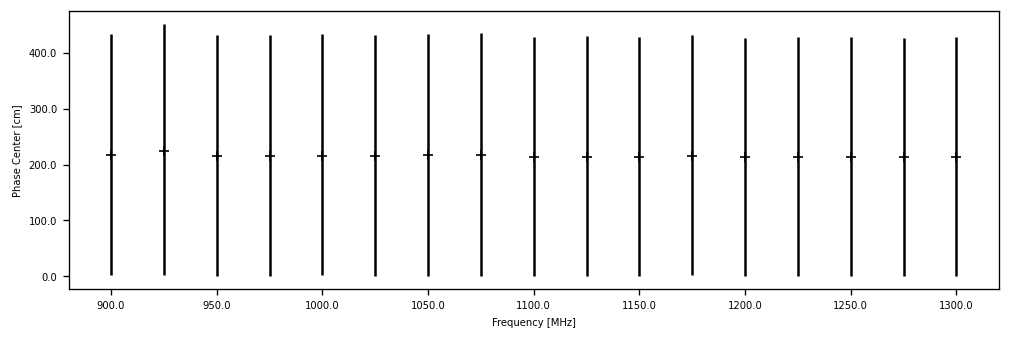

In [ ]:
data = (
    PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False")
    .groupby("FREQ")[["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]]
    .mean()
    .reset_index()
)
yerr_phys = data[["DZ_err_low_phys", "DZ_err_high_phys"]].T.values
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.errorbar(
    data.FREQ * 1000,
    data.DZ_phys,
    yerr=yerr_phys,
    fmt="+",
    label="Phase Center",
    color="black",
)
# ax.set_ylim(-130, -90)
ax.set_xlabel("Frequency [MHz]", fontsize=6)
ax.set_ylabel("Phase Center [cm]", fontsize=6)
ax.set_yticklabels(ax.get_yticks(), fontsize=6)
ax.set_xticklabels(ax.get_xticks(), fontsize=6)
plt.show();

ValueError: 'yerr' must not contain negative values

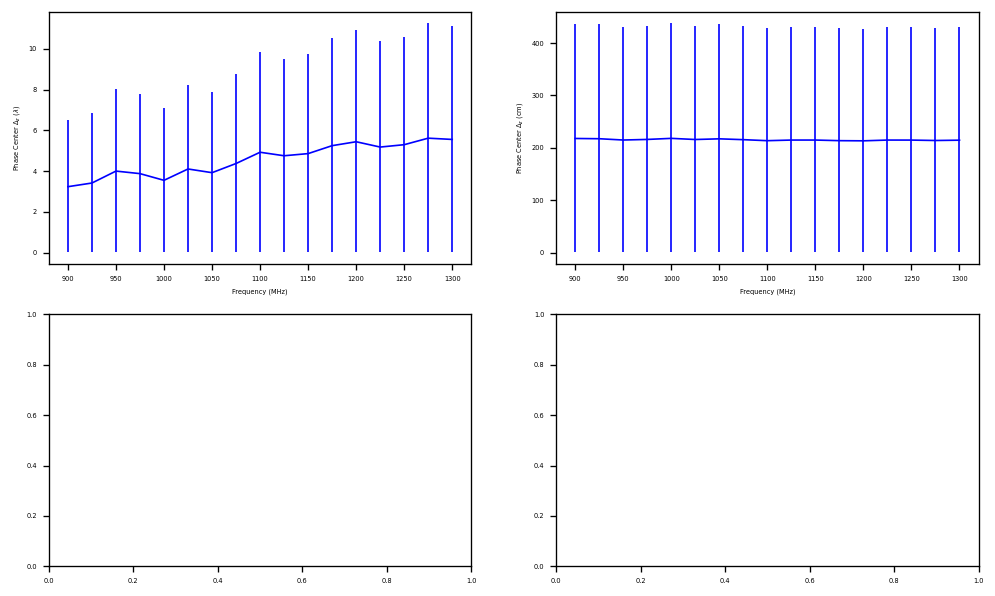

In [ ]:
PC.plot_phase_center(size=(10, 6));

### Predicted vs Measured phase patterns

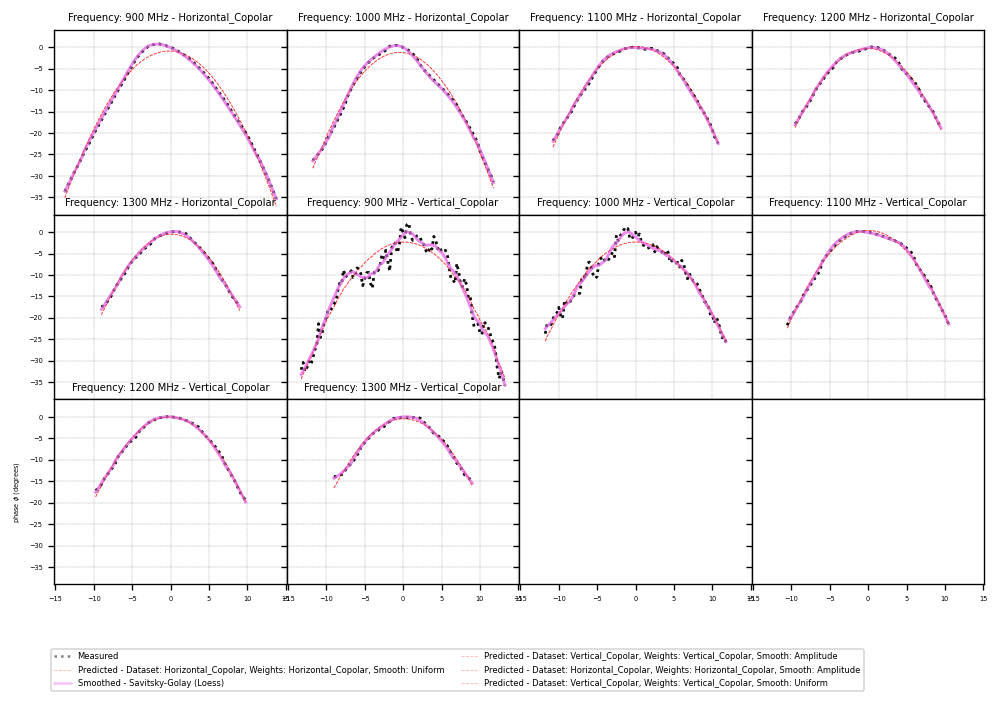

In [ ]:
freqs = PC.data.FREQ.unique()[::4]
PC.plot_phases(freqs=freqs, size=(10, 6));

### Scores

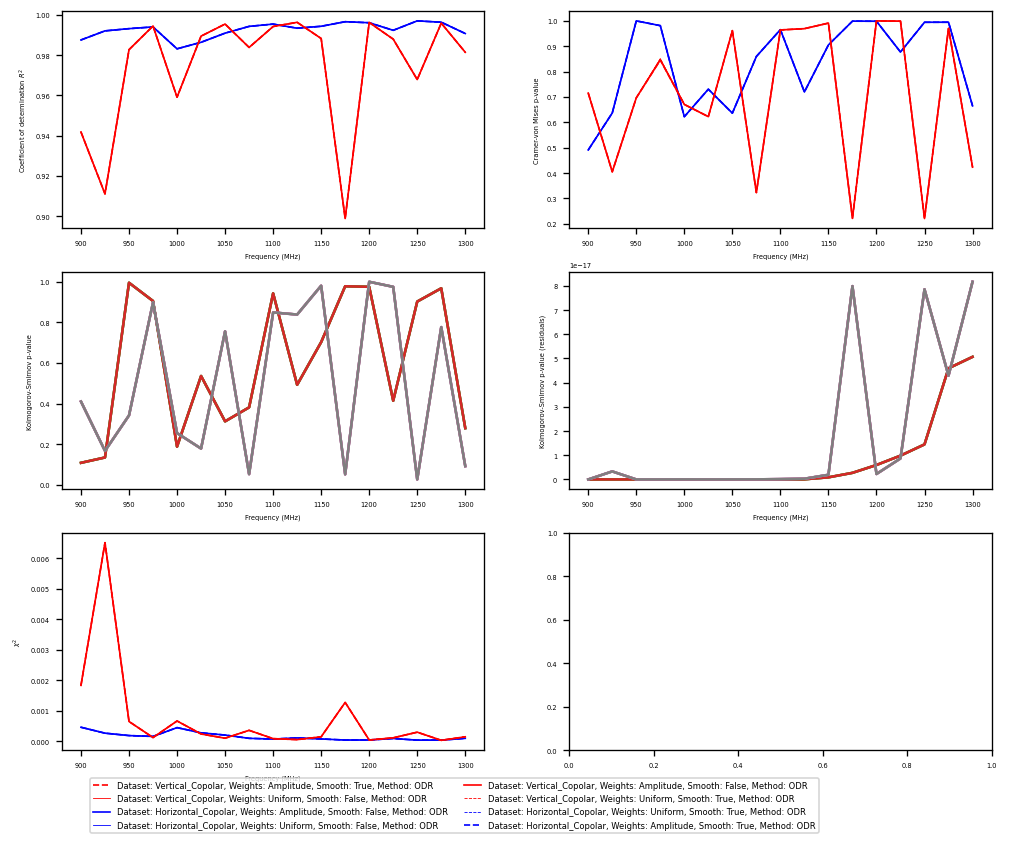

In [ ]:
PC.plot_statistics(size=(10, 8));

### Quantile plot for predicted and measured phase distributions.

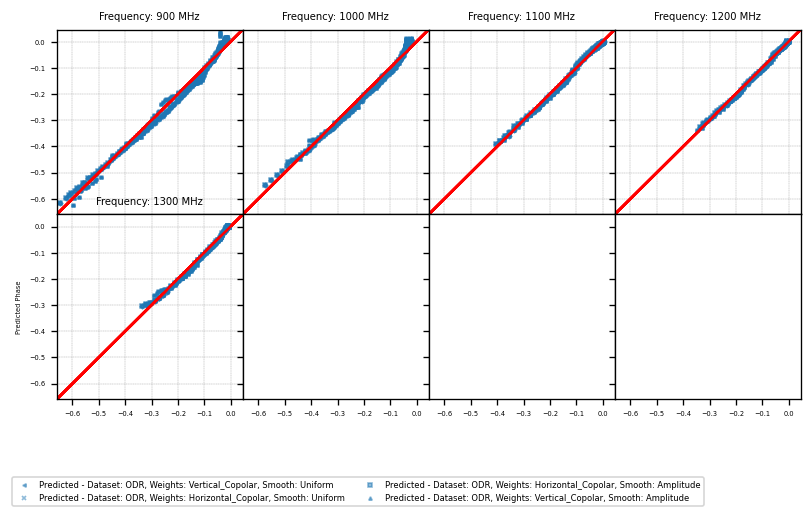

In [ ]:
PC.plot_residuals(freqs=freqs);

### Quantile Plot for residuals.

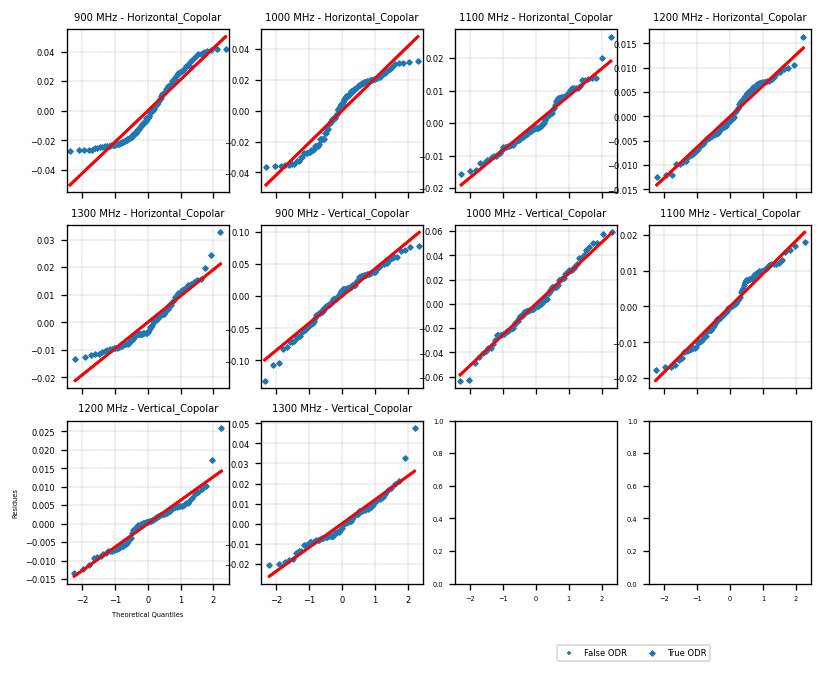

In [ ]:
PC.plot_qq_residuals(freqs=freqs);

## Concluding Remarks

- Cramer Von Mises test shows the googdness of fit, validating the procedure.
- Coefficient of determination indicates a large fraction of measured variance explained by the model.
- Kolmogorov-Smirnof test for residuals indicate that the residuals are not normal distributed.
- Chi squared is too low, combined with the other metrics we should consider large sistematics.
- We did not consider uncertainties for the measured data.
- Smoothing the data did not improve the fit substantially.
- Amplitude weighting had a significat positive impact for the goodness of fit.
- For any future measurements we may observe the following:
  - Measurements for very large angle are waste of time.
  - Rotation in azimuth should be done with the least possible angular resolution.
  - Information regading angle measurement uncertanties is important to obtain a sensible result.
  - Phase uncertanties may be obtained by taking several measurements of phase for each angle. This is easy to implement with VNAs and do not take considerable time. This procedure offer a quantification of phase variance and allows to consider different statistical tests, notably, Lack of Fit Test, and allows us to separate statistical noise from sistematics.
  - Measurement in fresnel region will have strong sistematics and it is not clear if any conclusive result would be drawn from the data.

## Code Availability

https://github.com/barosil/phase_center